In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


# **Library Import**

In [98]:
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv, global_mean_pool, global_max_pool, global_add_pool, BatchNorm, AttentionalAggregation, global_add_pool, LayerNorm
from torch.nn import Linear, CrossEntropyLoss, Dropout, Sequential
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# **Dataset Explaination**

In [9]:
# Load the Cardiotox dataset
dataset, info = tfds.load('cardiotox', with_info=True, as_supervised=False)

# Specify the base path to save the dataset in Google Drive
base_path = '/content/drive/My Drive/cardiotox_data'

# Loop over each split in the dataset dictionary
for split_name, split_data in dataset.items():
    split_save_path = f"{base_path}/{split_name}"
    split_data.save(split_save_path)
    print(f"Dataset split '{split_name}' saved to {split_save_path}")

Dataset split 'train' saved to /content/drive/My Drive/cardiotox_data/train
Dataset split 'validation' saved to /content/drive/My Drive/cardiotox_data/validation
Dataset split 'test' saved to /content/drive/My Drive/cardiotox_data/test
Dataset split 'test2' saved to /content/drive/My Drive/cardiotox_data/test2


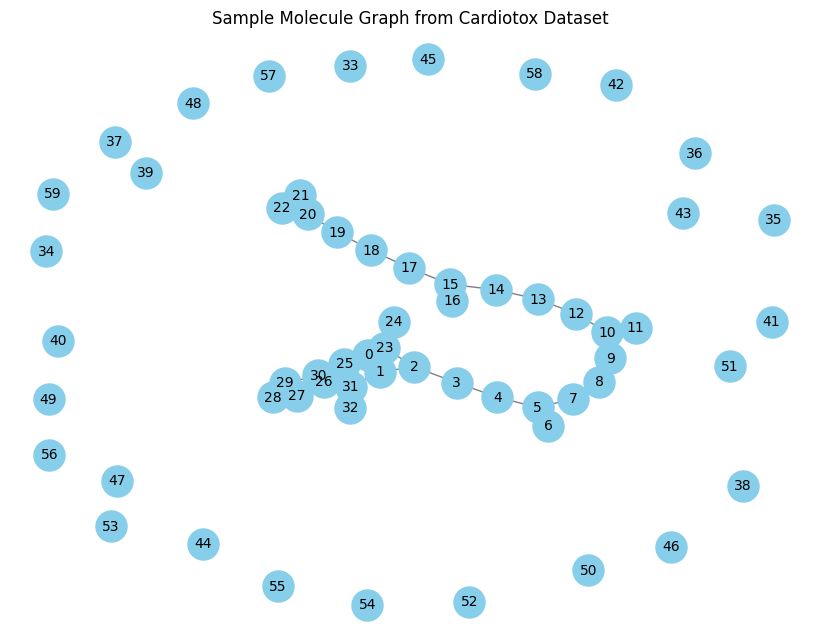

In [13]:
# Retrieve a single example from the dataset (train split)
example = next(iter(dataset['train']))

# Extract nodes and edges based on the atom features and pair mask
atom_features = example['atoms'].numpy()
pair_mask = example['pair_mask'].numpy()

# Create a NetworkX graph
G = nx.Graph()

# Add nodes for each atom
for i in range(len(atom_features)):
    G.add_node(i)

# Add edges based on the pair_mask (1 indicates a connection)
for i in range(pair_mask.shape[0]):
    for j in range(pair_mask.shape[1]):
        if pair_mask[i, j] == 1:
            G.add_edge(i, j)

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color="skyblue", node_size=500, edge_color="gray", font_size=10)
plt.title("Sample Molecule Graph from Cardiotox Dataset")
plt.show()

#**CardioTox Dataset**

The cardiotox dataset is designed for molecular analysis, particularly for studying molecular features that might contribute to cardiotoxicity (toxicity affecting the heart). This dataset is commonly used for classification tasks in computational biology, medicinal chemistry, and machine learning applications in drug discovery.

---

#**Dataset Overview**

The cardiotox dataset contains information on molecules, specifically targeting features that could predict whether a molecule exhibits cardiotoxic effects or not. The primary goal is to classify molecules as toxic (cardiotoxic) or non-toxic based on their structural and chemical properties.

---

#**Structure of Data**

The dataset is stored in a format compatible with TensorFlow Datasets (tfds), which makes it easy to use in machine learning workflows, especially in TensorFlow-based pipelines. Each molecule in the dataset is represented as a graph, where:

*   **Nodes** represent atoms.
*   **Edges** represent bonds or interactions between atoms.


---


#**Molecular Representation in the Dataset**

In this dataset, each molecule is represented with various fields, which include:



1.   **Graph-Level Properties:**

    *   **molecule_id:** A unique identifier for each molecule. This is typically represented as a SMILES string (Simplified Molecular Input Line Entry System), which is a notation that encodes the structure of the molecule in a text string. SMILES strings are commonly used to represent molecular structures.

    *   **active:** A label indicating the toxicity of the molecule. This label is usually represented as a binary value (1 for toxic, 0 for non-toxic).


2.   **Node-Level Features:**

    *   **atom_mask:** A binary mask indicating the presence of atoms in the molecule. Since each molecule may have a different number of atoms, the atom_mask allows for a consistent representation by padding molecules with fewer atoms. In the dataset, an entry in atom_mask is 1 if an atom is present at that position and 0 otherwise.

    *   **atoms:** A feature matrix representing the atoms in the molecule. Each row corresponds to an atom and contains a feature vector that captures chemical properties of the atom, such as atom type, valency, hybridization, and other properties.


3. **Edge-Level Features:**

    * **pair_mask:** An adjacency matrix representing connections (bonds) between atoms. The pair_mask is typically a symmetric matrix where a 1 in position (i, j) indicates a bond between atom i and atom j, and 0 indicates no bond.

    * **pairs:** A tensor representing additional features of each bond or edge in the molecule. For example, this might include bond types (e.g., single, double, triple) or other interaction-specific properties.



---

#**Graph Representation of Molecules**

The graph representation of each molecule in this dataset is particularly suitable for graph neural networks (GNNs), where nodes (atoms) and edges (bonds) can be passed through specialized layers that learn relationships in graph-structured data.

In a GNN setup:

* Each atom in the molecule graph is represented as a node with its feature vector from the atoms matrix.

* Each bond is represented as an edge between nodes, defined by the pair_mask adjacency matrix.

* Edge features from the pairs matrix can provide additional context for the type of interaction between two atoms.


This graph-based representation allows models to capture both local (e.g., neighboring atoms) and global (e.g., overall structure) molecular features, which are essential for predicting properties like toxicity.







# **Visualize Data**

In [16]:
def load_single_graph():
    # Load the Cardiotox dataset, taking only one sample
    ds, _ = tfds.load('cardiotox', split='train', with_info=True, as_supervised=False)
    for example in tfds.as_numpy(ds.take(1)):  # Taking just one sample for visualization
        # Extract node features
        node_features = torch.tensor(example['atoms'], dtype=torch.float)

        # Extract edges from the pair_mask adjacency matrix
        pair_mask = example['pair_mask']
        edge_indices_np = np.vstack(np.nonzero(pair_mask))  # Gets the indices of non-zero entries

        # Convert the indices to a PyTorch tensor
        edge_index = torch.tensor(edge_indices_np, dtype=torch.long)

        # Create a Data object for PyTorch Geometric
        data = Data(x=node_features, edge_index=edge_index)
        return data

In [17]:
def plot_graph(data):
    # Check the shape of edge_index to confirm it's correct
    if data.edge_index.size(0) != 2:
        raise ValueError("Edge index must have a size of 2 in the first dimension.")

    # Convert to a networkx graph
    G = to_networkx(data, to_undirected=True)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, node_size=700, node_color="skyblue", with_labels=True, font_weight='bold')
    plt.title("Graph Visualization")
    plt.show()


In [18]:
# Load a single graph from the dataset
single_graph = load_single_graph()

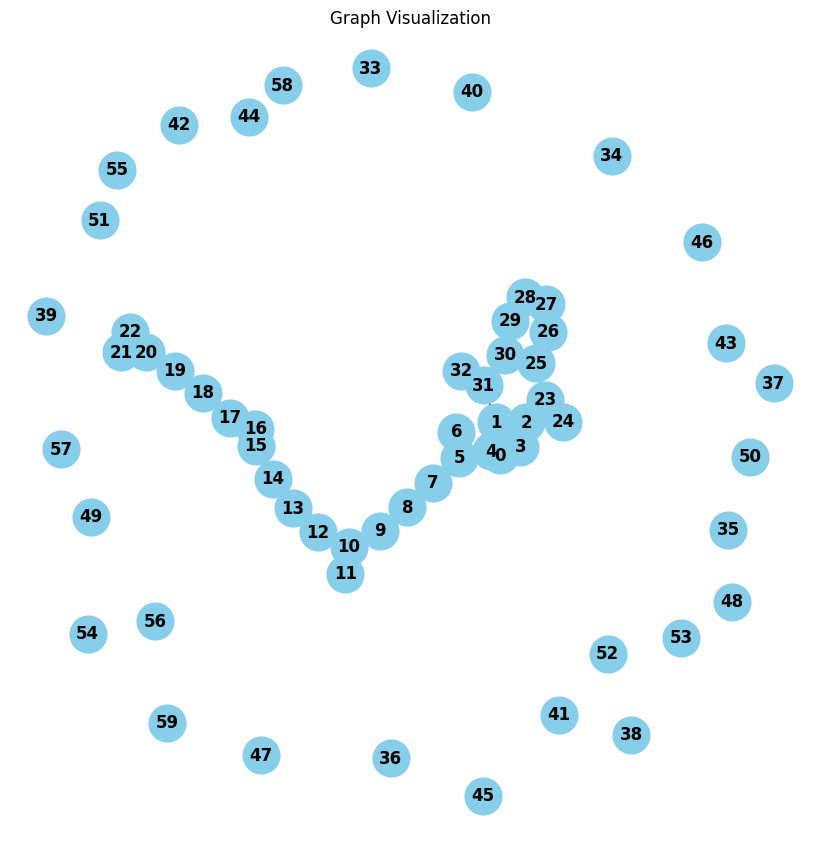

In [19]:
# Plot the graph
plot_graph(single_graph)

# **Load Data**

In [26]:
def load_data(split):
    # Load the dataset and get information about it
    ds, ds_info = tfds.load('cardiotox', split=split, with_info=True, as_supervised=False)
    graph_data_list = []

    for example in tfds.as_numpy(ds):
        # Convert node features to a PyTorch tensor
        node_features = torch.tensor(example['atoms'], dtype=torch.float)

        # Extract edge indices from pair_mask and transpose to match PyTorch Geometric format
        edge_index = torch.nonzero(torch.tensor(example['pair_mask']), as_tuple=False).t().contiguous()

        # Extract edge attributes if available in 'pairs' and match edge_index
        edge_attr = torch.tensor(example['pairs'][edge_index[0], edge_index[1]], dtype=torch.float)

        # Target label - assuming the second value in 'active' array indicates toxicity
        label = torch.tensor(example['active'][1], dtype=torch.long)

        # Create the Data object for PyTorch Geometric
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=label)

        # Append to the list of graphs
        graph_data_list.append(data)

    # Return a DataLoader with batched data
    return DataLoader(graph_data_list, batch_size=32, shuffle=True)

In [27]:
# Load the datasets
train_data = load_data('train')
val_data = load_data('validation')  # Adjust the split name if necessary
test_data = load_data('test')

#**Graph Convlution Network**

This is a deep Graph Convolutional Network (GCN) designed for graph-based binary classification tasks, such as predicting molecular toxicity. Let's break down the structure and the function of each component in detail.



---

##**Model Architecture Overview**

This network is a multi-layer GCN with batch normalization and dropout. It uses graph convolutional layers to capture local structural information of the graph and a series of fully connected (linear) layers for final classification. Here’s an outline of each part:

* **Graph Convolutional Layers (GCNConv):** Four GCN layers extract hierarchical features from the graph by aggregating information from each node’s neighbors.

* **Batch Normalization:** Helps stabilize and accelerate training by normalizing the output of each layer.

* **Dropout:** Prevents overfitting by randomly "dropping" units during training.

* **Graph Pooling:** Combines the node-level representations into a single graph-level representation.

* **Fully Connected Layers:** Maps the pooled graph representation to the final binary classification output.



---

##**Layer-by-Layer Breakdown**

**Graph Convolutional Layers (GCNConv)**

Each GCNConv layer operates on the node features x and the edge_index:

* Input and Output Dimensions: Each GCN layer transforms node features from one dimension to another, with:

    * The first layer transforming input features of dimension 27 to 64.
    * The second layer transforming 64 features to 128.
    * The third layer reducing 128 features back to 64.
    * The fourth layer reducing 64 features down to 32.

Each GCN layer aggregates information from neighboring nodes, effectively capturing the local structure and information around each node.

The output of a GCN layer is a new set of node embeddings that have been influenced by each node’s neighbors, allowing the network to learn local graph patterns.

**Batch Normalization (BatchNorm)**

After each GCN layer, batch normalization is applied to the output:

* Function: Batch normalization normalizes the output of each layer to have a consistent distribution, which can stabilize learning and reduce internal covariate shift.

* Benefit in GCNs: In GNNs, normalization helps with training stability, especially in deep networks, by keeping node features on a consistent scale.

**Dropout Layers**

Dropout is applied after each GCN layer and before the fully connected layers:

* Function: Dropout randomly sets a fraction of the activations to zero during training, which helps prevent overfitting.

* Dropout Rate: Here, a dropout rate of 0.3 (30%) is used. This means that 30% of the nodes will be randomly dropped out in each layer during training.


**Pooling Layers**

After the four GCN layers, we have pooling layers to create a graph-level representation from the node-level embeddings:

* Function: Pooling layers aggregate node-level features to create a single representation for the entire graph.
    * global_mean_pool: Takes the average of the node embeddings for each graph.

    * global_max_pool: Takes the maximum value of the node embeddings.
    * global_add_pool: Sums up the node embeddings for each graph.

* Combined Pooling: By using mean, max, and add pooling together, the model can capture a richer set of information about the graph’s structure and node embeddings. This combination provides a robust summary of the graph, enabling the model to learn more nuanced graph-level features.



---

##**Working Flow of the Model (Forward Pass)**

1. Input: Node features x (of shape [num_nodes, 27]), edge_index (graph structure), and batch (to identify graph instances in a batch).

2. GCN Layers:

    * Pass x through each GCN layer, followed by ReLU activation, batch normalization, and dropout.
    * This process refines the node features at each layer by aggregating neighborhood information and applying non-linear transformations.

3. Graph Pooling:
    
    * After the GCN layers, use mean, max, and add pooling to aggregate the node features into a single graph-level representation.

4. Fully Connected Layers:

    * Pass the pooled graph-level representation through two fully connected layers with ReLU activations, dropout, and finally log-softmax for binary classification.


In [28]:
class AdvancedGNN(torch.nn.Module):
    def __init__(self):
        super(AdvancedGNN, self).__init__()

        # Define GCN layers with increasing complexity
        self.conv1 = GCNConv(27, 64)   # First GCN layer
        self.conv2 = GCNConv(64, 128)  # Second GCN layer
        self.conv3 = GCNConv(128, 64)  # Third GCN layer
        self.conv4 = GCNConv(64, 32)   # Fourth GCN layer

        # Batch normalization for stabilizing learning
        self.bn1 = BatchNorm(64)
        self.bn2 = BatchNorm(128)
        self.bn3 = BatchNorm(64)
        self.bn4 = BatchNorm(32)

        # Fully connected layers with dropout for regularization
        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GCN layer with ReLU and batch normalization
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)

        # Second GCN layer with ReLU and batch normalization
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)

        # Third GCN layer with ReLU and batch normalization
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)

        # Fourth GCN layer with ReLU and batch normalization
        x = F.relu(self.bn4(self.conv4(x, edge_index)))

        # Graph-level pooling to get a single representation for the entire graph
        x = global_mean_pool(x, batch) + global_max_pool(x, batch) + global_add_pool(x, batch)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc2(x)      # Output layer for binary classification

        return F.log_softmax(x, dim=1)


In [29]:
# Instantiate model, optimizer, and criterion
model = AdvancedGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [30]:
def train(train_data):
    model.train()
    total_loss = 0
    for data in train_data:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)  # Ensure data.y is the correct graph-level label
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_data)


In [31]:
def test(test_data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()  # Ensure data.y is the correct graph-level label
            total += len(data.y)
    return correct / total


In [32]:
# Example usage
train_loss = train(train_data)
print(f'Average Training Loss: {train_loss:.4f}')

Average Training Loss: 0.5419


In [33]:
test_accuracy = test(test_data)
print(f'Accuracy: {test_accuracy * 100:.2f}%')

Accuracy: 80.81%


# **Graph Attention Network**

This is an advanced Graph Attention Network (GAT) designed for binary classification tasks, such as predicting molecular properties like toxicity. The network uses multi-head attention in the GAT layers to capture complex interactions between nodes and employs pooling and fully connected layers to produce a final classification.

##**Model Architecture Overview**

This GAT model is structured with:

* **Graph Attention Layers (GATConv):** Three GAT layers that use multi-head attention to extract local structural information with an emphasis on important neighbors.
* **Batch Normalization:** Stabilizes learning and accelerates convergence.
* **Dropout:** Prevents overfitting by randomly dropping activations during training.
* **Pooling Layers:** Aggregates node-level embeddings into a single graph-level embedding.
* **Fully Connected Layers:** Processes the pooled graph representation to produce the final classification.



---

##**Working of a GAT Layer**
A Graph Attention Network (GAT) layer is a type of graph neural network layer that incorporates an attention mechanism to allow nodes in a graph to selectively focus on their neighbors. This is particularly useful for graph data, as it enables nodes to weigh information from different neighbors differently based on their relevance.

**Key Concepts in a GAT Layer**
* **Attention Mechanism:** Unlike traditional GCN layers, which treat all neighbors equally, a GAT layer applies an attention mechanism that assigns a unique weight (attention score) to each neighbor. This allows the network to focus more on certain nodes that are more important to the central node.

* **Multi-Head Attention:** A GAT layer often uses multiple attention "heads," each learning a separate set of attention weights. This allows the model to capture diverse aspects of the node's neighborhood.

* **Shared Attention Weights:** The attention weights are shared across all nodes, so the model can learn a generalized attention mechanism that applies to all nodes in the graph.

In [34]:
class AdvancedGAT(torch.nn.Module):
    def __init__(self):
        super(AdvancedGAT, self).__init__()

        # GAT layers with multi-head attention
        self.conv1 = GATConv(in_channels=27, out_channels=16, heads=8, concat=True, dropout=0.2)  # First GAT layer
        self.conv2 = GATConv(in_channels=16*8, out_channels=32, heads=4, concat=True, dropout=0.2)  # Second GAT layer
        self.conv3 = GATConv(in_channels=32*4, out_channels=64, heads=2, concat=True, dropout=0.2)  # Third GAT layer

        # Batch normalization layers
        self.bn1 = BatchNorm(16*8)
        self.bn2 = BatchNorm(32*4)
        self.bn3 = BatchNorm(64*2)

        # Fully connected layers for classification
        self.fc1 = torch.nn.Linear(64*2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GAT layer with ELU activation and batch normalization
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)

        # Second GAT layer with ELU activation and batch normalization
        x = F.elu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)

        # Third GAT layer with ELU activation and batch normalization
        x = F.elu(self.bn3(self.conv3(x, edge_index)))

        # Graph-level pooling to get a single representation for the entire graph
        x = global_mean_pool(x, batch) + global_max_pool(x, batch)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer for binary classification

        return F.log_softmax(x, dim=1)


In [35]:
# Instantiate the model, optimizer, and criterion
model = AdvancedGAT()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = CrossEntropyLoss()

In [36]:
# Training function
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


In [37]:
# Testing function
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

In [38]:
# Example usage
train_loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {train_loss:.4f}')

Average Training Loss: 0.4754


In [39]:
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 34.80%


# **Hybrid Graph Attention Network (GAT) and Graph Convolutional Network (GCN) Model**

In [70]:
class HybridGAT_GCN(torch.nn.Module):
    def __init__(self):
        super(HybridGAT_GCN, self).__init__()

        # Initial GAT layers with multi-head attention
        self.gat1 = GATConv(27, 64, heads=4, concat=True, dropout=0.2)   # Output: 64*4 = 256
        self.gat2 = GATConv(256, 128, heads=2, concat=True, dropout=0.2)  # Output: 128*2 = 256

        # Linear layer to match dimensions for the skip connection
        self.lin1 = Linear(256, 128)

        # GCN layers
        self.gcn1 = GCNConv(128, 128)
        self.gcn2 = GCNConv(128, 64)

        # Batch normalization layers
        self.bn1 = BatchNorm(256)
        self.bn2 = BatchNorm(256)
        self.bn3 = BatchNorm(128)
        self.bn4 = BatchNorm(64)

        # Attention-based pooling
        self.attention_pool = AttentionalAggregation(gate_nn=Linear(64, 1), nn=Linear(64, 64))

        # Fully connected layers for final classification
        self.fc1 = Linear(64, 32)
        self.fc2 = Linear(32, 2)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GAT layer with ELU activation and batch normalization
        x = F.elu(self.bn1(self.gat1(x, edge_index)))
        x = self.dropout(x)

        # Second GAT layer with ELU activation and batch normalization
        x = F.elu(self.bn2(self.gat2(x, edge_index)))
        x = self.dropout(x)

        # Reduce dimension for skip connection compatibility
        x = self.lin1(x)

        # First GCN layer with batch normalization and skip connection from GAT layers
        x = F.elu(self.bn3(self.gcn1(x, edge_index) + x))  # Skip connection

        # Second GCN layer with batch normalization
        x = F.elu(self.bn4(self.gcn2(x, edge_index)))

        # Attention-based global pooling
        x = self.attention_pool(x, batch)

        # Fully connected layers for classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [71]:
# Instantiate the model, optimizer, and criterion
model = HybridGAT_GCN()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = CrossEntropyLoss()

In [72]:
# Training function
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [73]:
# Testing function
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

In [74]:
# Example usage
train_loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {train_loss:.4f}')


Average Training Loss: 0.4590


In [75]:
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 84.51%


# **GraphSAGE**

This is a GraphSAGE (Graph Sample and Aggregation) network tailored for a graph-level binary classification task. GraphSAGE is a type of Graph Neural Network (GNN) that learns node embeddings by aggregating features from a node’s neighborhood. This particular architecture is optimized by using batch normalization, dropout for regularization, and multiple pooling methods to combine the node-level features into a graph-level representation.


---



##1. **Model Architecture Overview**

The OptimizedGraphSAGE model consists of:

* **GraphSAGE Convolutional Layers:** Two layers of GraphSAGE convolutions to capture local neighborhood information for each node in the graph.

* **Batch Normalization Layers:** Applied after each convolution to stabilize learning.

* **Pooling Layers:** Multiple pooling methods (mean, max, and add pooling) are used to aggregate the learned node embeddings into a graph-level representation.

* **Fully Connected Layers:** These layers transform the pooled graph-level representation into the final binary classification output.


---




##2. **How GraphSAGE Works:**

* In GraphSAGE, each layer aggregates information from neighboring nodes. Specifically, for each node
𝑖
, GraphSAGE computes a new embedding by combining its own feature vector with the aggregated feature vectors of its neighbors.

* Mean Aggregation: In this case, the mean of the neighboring nodes' features is calculated, which is then concatenated or combined with the node’s own features.
The GraphSAGE aggregation formula for each node
𝑖


In [89]:
class OptimizedGraphSAGE(torch.nn.Module):
    def __init__(self):
        super(OptimizedGraphSAGE, self).__init__()

        # Reduced GraphSAGE layers with mean aggregation
        self.conv1 = SAGEConv(in_channels=27, out_channels=64, aggr='mean')
        self.conv2 = SAGEConv(in_channels=64, out_channels=128, aggr='mean')

        # Batch normalization layers
        self.bn1 = BatchNorm(64)
        self.bn2 = BatchNorm(128)

        # Pooling layers for graph-level feature combination
        self.fc1 = Linear(128, 64)
        self.fc2 = Linear(64, 2)

        # Dropout for regularization with reduced rate
        self.dropout = Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GraphSAGE layer with residual connection
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Second GraphSAGE layer with residual connection
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)

        # Combine graph-level representations from multiple pooling layers
        x = global_mean_pool(x2, batch) + global_max_pool(x2, batch) + global_add_pool(x2, batch)

        # Fully connected layers for classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [90]:
# Instantiate the model, optimizer, and criterion
model = OptimizedGraphSAGE()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()


In [91]:
# Training function
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


In [92]:
# Testing function
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

In [93]:
# Train and evaluate the model
train_loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {train_loss:.4f}')

Average Training Loss: 0.5381


In [94]:
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 85.34%


# **Graph Isomorphic Network**

Thia is an advanced Graph Isomorphism Network (GIN), a type of Graph Neural Network (GNN) that is specifically designed to capture structural information in graph data. GIN is particularly powerful for tasks requiring a high level of structural understanding, such as molecular property prediction or other chemistry-related tasks. This advanced architecture is enhanced with batch normalization, dropout, attention-based pooling, and fully connected layers for graph-level classification.


---
##**Model Architecture Overview**

The AdvancedGIN model consists of:

* **Graph Isomorphism Layers (GINConv):** Three GIN layers that use multi-layer perceptrons (MLPs) to capture complex node relationships and are known for their expressive power.

* **Batch Normalization:** Applied after each GIN layer to stabilize training and accelerate convergence.

* **Attention-Based Pooling:** A specialized pooling method that learns the importance of each node to generate a single graph-level embedding.

* **Fully Connected Layers:** These layers take the pooled graph-level embedding and transform it for binary classification.

* **Dropout:** Regularization technique to prevent overfitting.


---


##**Graph Isomorphism Layers (GINConv)**
Each GIN layer in this network applies a GINConv operation, which is based on the concept of graph isomorphism:

**Structure of Each GIN Layer:**

* Each GIN layer contains an MLP (multi-layer perceptron) with multiple linear layers and ReLU activations.
* The MLP acts as a feature extractor, learning a transformation for each node's features based on the node itself and its neighborhood.

**How GIN Works:**

* GIN layers use an MLP to aggregate information from a node’s neighbors and combine it with the node’s own features.

* Unlike traditional GCNs, which use a simple weighted sum, GIN’s use of MLPs allows it to be more expressive in distinguishing different graph structures.

In [104]:
class AdvancedGIN(torch.nn.Module):
    def __init__(self):
        super(AdvancedGIN, self).__init__()

        # Define MLPs for each GINConv layer
        nn1 = Sequential(
            Linear(27, 64),
            torch.nn.ReLU(),
            Linear(64, 64),
            torch.nn.ReLU(),
            Linear(64, 128)
        )
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(128)

        nn2 = Sequential(
            Linear(128, 128),
            torch.nn.ReLU(),
            Linear(128, 128),
            torch.nn.ReLU(),
            Linear(128, 128)
        )
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(128)

        nn3 = Sequential(
            Linear(128, 128),
            torch.nn.ReLU(),
            Linear(128, 128),
            torch.nn.ReLU(),
            Linear(128, 64)
        )
        self.conv3 = GINConv(nn3)
        self.bn3 = BatchNorm(64)

        # Attention-based pooling layer
        self.attention_pool = AttentionalAggregation(gate_nn=Linear(64, 1), nn=Linear(64, 64))

        # Fully connected layers for classification
        self.fc1 = Linear(64, 32)
        self.fc2 = Linear(32, 16)
        self.fc3 = Linear(16, 2)

        # Dropout for regularization
        self.dropout = Dropout(0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GIN layer with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)

        # Second GIN layer with batch normalization and dropout
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)

        # Third GIN layer with batch normalization
        x = F.relu(self.bn3(self.conv3(x, edge_index)))

        # Attention-based global pooling
        x = self.attention_pool(x, batch)

        # Fully connected layers for classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [105]:
# Instantiate the model, optimizer, and criterion
model = AdvancedGIN()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = CrossEntropyLoss()

In [106]:
# Training and testing functions remain the same
train_loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {train_loss:.4f}')

Average Training Loss: 0.4882


In [107]:
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 93.68%


# **EDA**

Basic Statistics:
           is_toxic    num_atoms  dist2topk_nbs  pair_mask_sum
count  6523.000000  6523.000000         6523.0    6523.000000
mean      0.263836    25.505749            0.0      55.260155
std       0.440745    10.937708            0.0      24.801704
min       0.000000     1.000000            0.0       0.000000
25%       0.000000    17.000000            0.0      36.000000
50%       0.000000    26.000000            0.0      58.000000
75%       1.000000    33.000000            0.0      72.000000
max       1.000000    60.000000            0.0     136.000000


<ipython-input-108-0c7696413bf7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='is_toxic', palette='viridis')


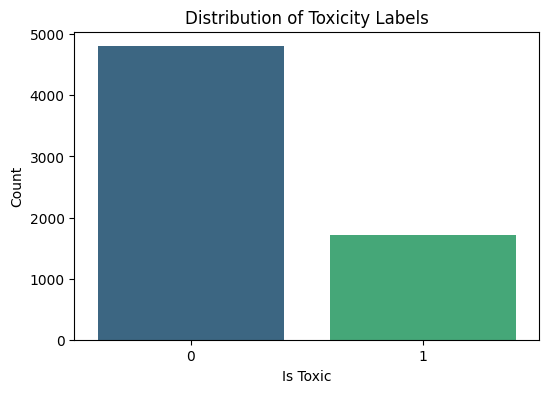

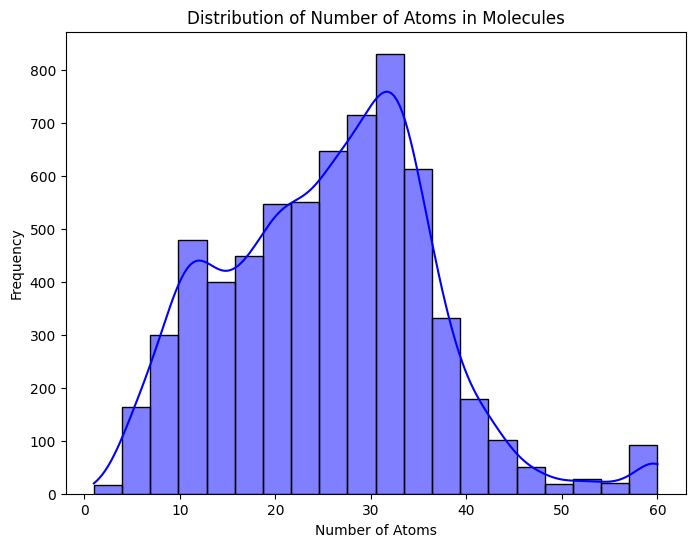

<ipython-input-108-0c7696413bf7>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='num_atoms', palette='coolwarm')


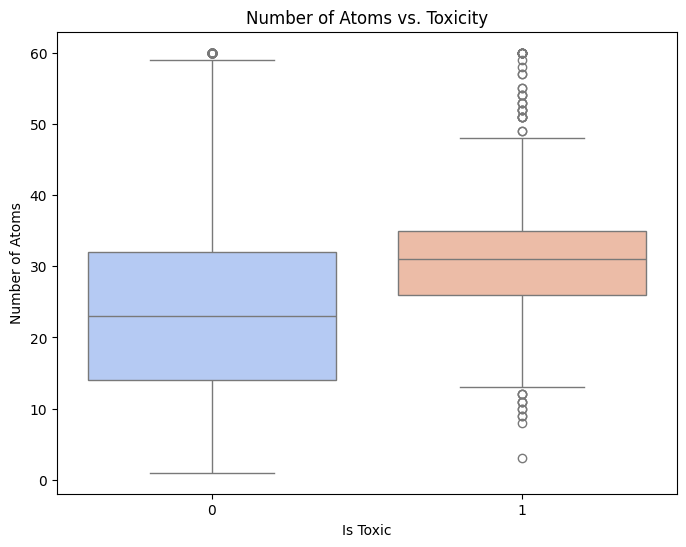

<ipython-input-108-0c7696413bf7>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='pair_mask_sum', palette='coolwarm')


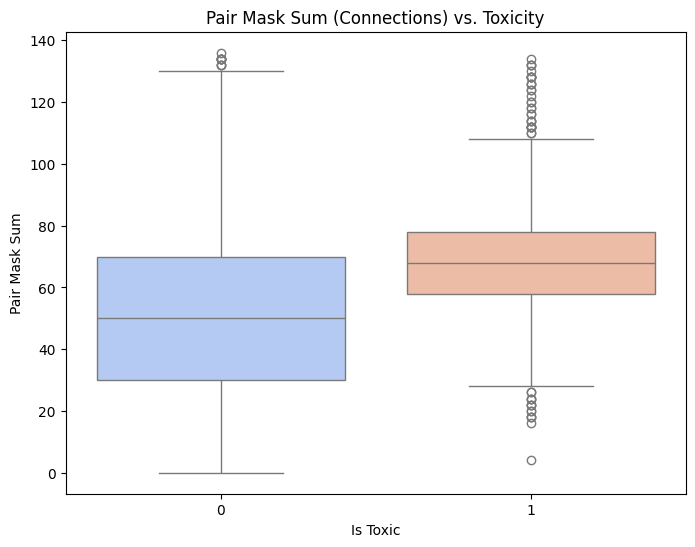

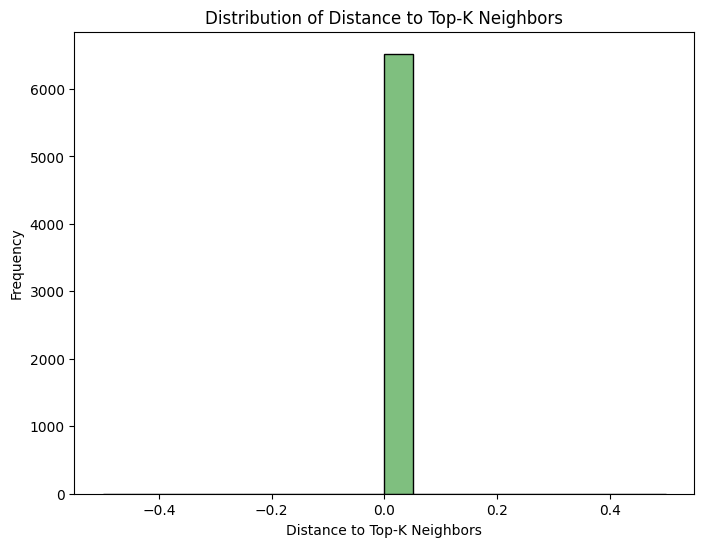

ValueError: could not convert string to float: 'CC1=C(C/C=C(\\C)CCC[C@H](C)CCC[C@H](C)CCCC(C)C)C(=O)c2ccccc2C1=O'

<Figure size 800x600 with 0 Axes>

In [108]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Load the Cardiotox dataset and convert to numpy for EDA
ds, info = tfds.load('cardiotox', split='train', with_info=True, as_supervised=False)
data_list = []

for example in tfds.as_numpy(ds):
    data_dict = {
        'molecule_id': example['molecule_id'].decode('utf-8'),
        'is_toxic': example['active'][1],  # Assuming active[1] is the toxicity label
        'num_atoms': np.sum(example['atom_mask']),  # Count non-zero atoms
        'dist2topk_nbs': example['dist2topk_nbs'][0],
        'pair_mask_sum': np.sum(example['pair_mask']),  # Number of bonds or connections
    }
    data_list.append(data_dict)

# Convert to DataFrame
df = pd.DataFrame(data_list)

# Basic statistics
print("Basic Statistics:\n", df.describe())

# Distribution of target variable (Toxic vs. Non-Toxic)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_toxic', palette='viridis')
plt.title("Distribution of Toxicity Labels")
plt.xlabel("Is Toxic")
plt.ylabel("Count")
plt.show()

# Distribution of number of atoms
plt.figure(figsize=(8, 6))
sns.histplot(df['num_atoms'], bins=20, kde=True, color='blue')
plt.title("Distribution of Number of Atoms in Molecules")
plt.xlabel("Number of Atoms")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of number of atoms vs. toxicity
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_toxic', y='num_atoms', palette='coolwarm')
plt.title("Number of Atoms vs. Toxicity")
plt.xlabel("Is Toxic")
plt.ylabel("Number of Atoms")
plt.show()

# Distribution of pair mask sum (connections) vs. toxicity
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_toxic', y='pair_mask_sum', palette='coolwarm')
plt.title("Pair Mask Sum (Connections) vs. Toxicity")
plt.xlabel("Is Toxic")
plt.ylabel("Pair Mask Sum")
plt.show()

# Distribution of distance to top-k neighbors
plt.figure(figsize=(8, 6))
sns.histplot(df['dist2topk_nbs'], bins=20, kde=True, color='green')
plt.title("Distribution of Distance to Top-K Neighbors")
plt.xlabel("Distance to Top-K Neighbors")
plt.ylabel("Frequency")
plt.show()

# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Features")
plt.show()


Basic Statistics of Graph Dataset:
          num_nodes    num_edges   avg_degree      density  toxicity_label
count  6523.000000  6523.000000  6523.000000  6523.000000     6523.000000
mean     25.505749    27.630078     2.127304     0.113879        0.263836
std      10.937716    12.400839     0.164370     0.077561        0.440745
min       1.000000     0.000000     0.000000     0.000000        0.000000
25%      17.000000    18.000000     2.074074     0.069519        0.000000
50%      26.000000    29.000000     2.171429     0.086154        0.000000
75%      33.000000    36.000000     2.230769     0.130719        1.000000
max      60.000000    68.000000     2.489796     1.000000        1.000000


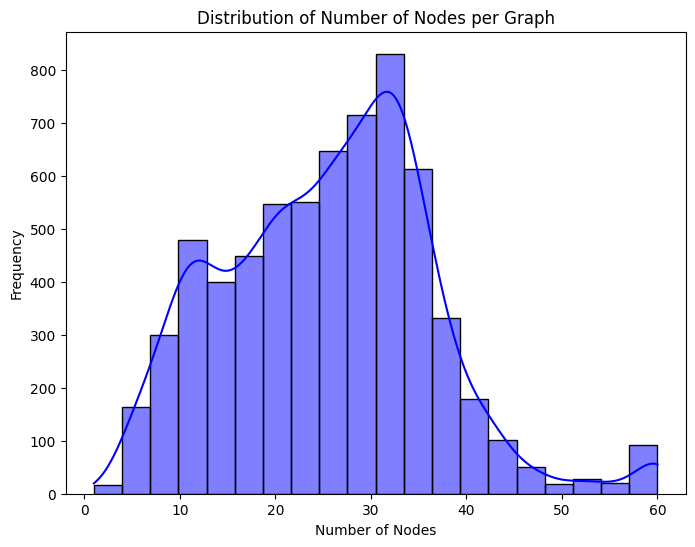

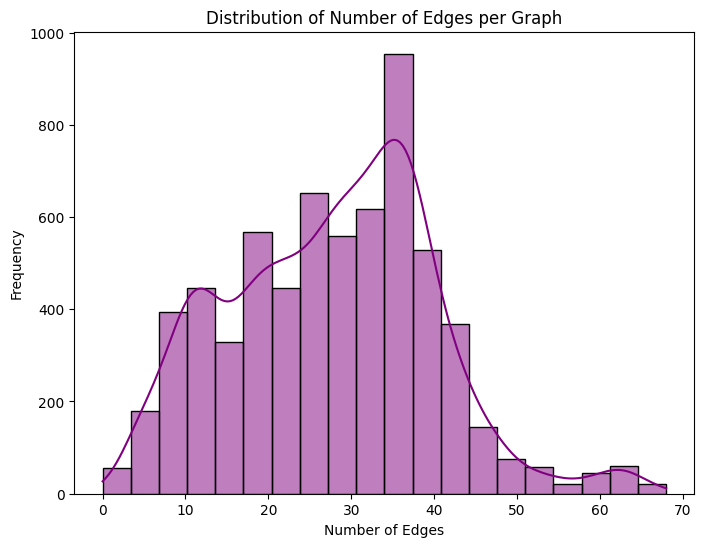

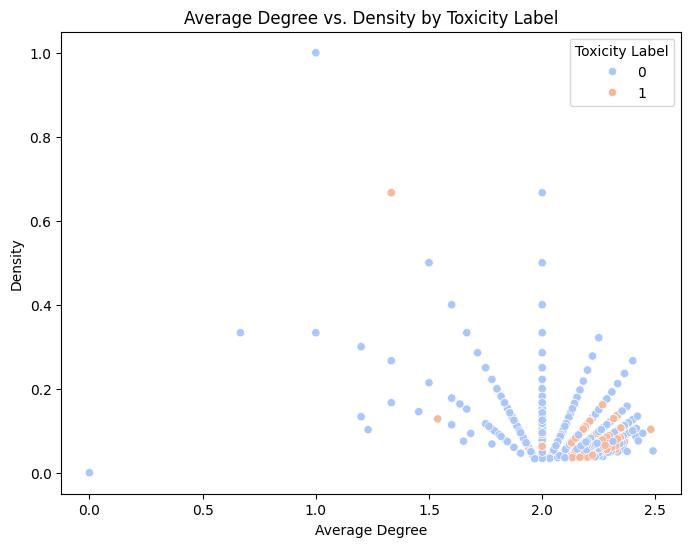

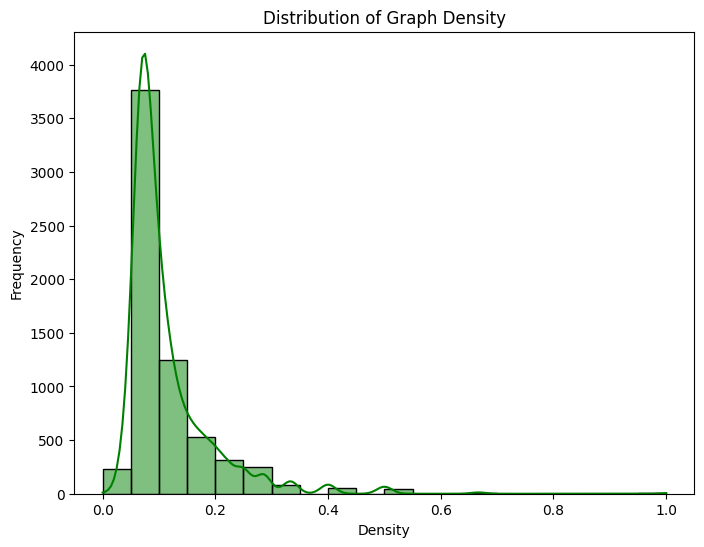

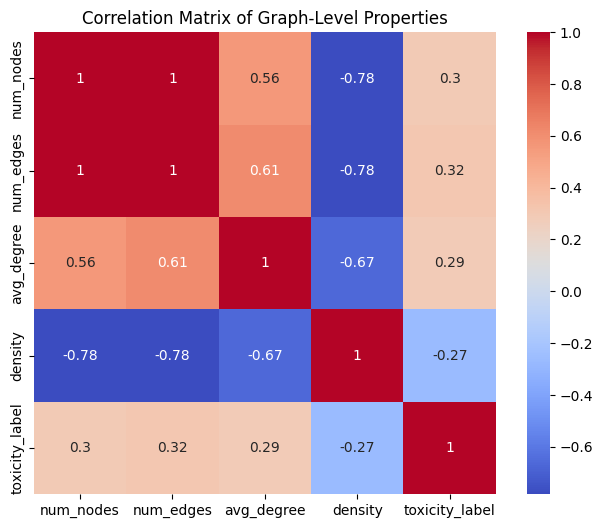

<ipython-input-109-3ade8e15930a>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='toxicity_label', palette='viridis')


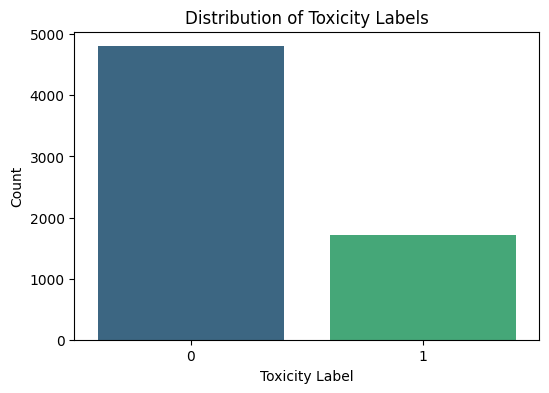

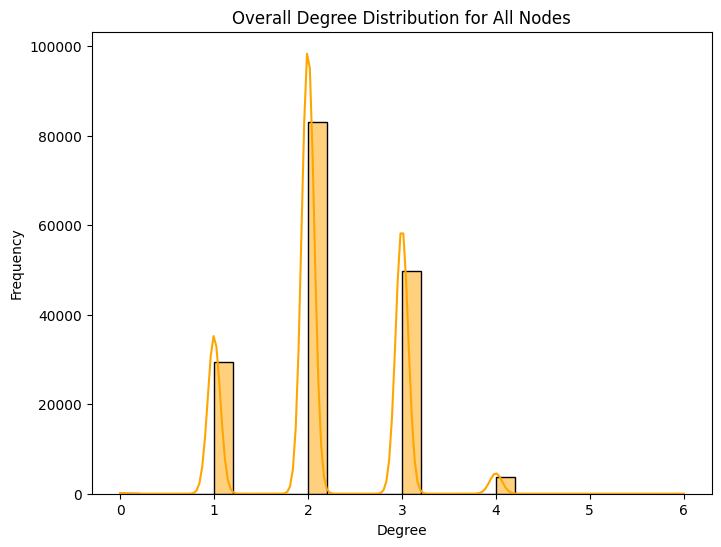

In [109]:
import tensorflow_datasets as tfds
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Cardiotox dataset
ds, info = tfds.load('cardiotox', split='train', with_info=True, as_supervised=False)

# Initialize lists to store graph properties
num_nodes_list = []
num_edges_list = []
avg_degree_list = []
density_list = []
toxicity_labels = []

for example in tfds.as_numpy(ds):
    # Convert edge_index and atom_mask into a NetworkX graph
    atom_mask = example['atom_mask']
    pair_mask = example['pair_mask']
    G = nx.Graph()

    # Add nodes based on atom_mask
    for i, active in enumerate(atom_mask):
        if active:
            G.add_node(i)

    # Add edges based on pair_mask (assume symmetric adjacency matrix)
    for i in range(pair_mask.shape[0]):
        for j in range(i + 1, pair_mask.shape[1]):
            if pair_mask[i, j] > 0:
                G.add_edge(i, j)

    # Calculate graph properties
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    avg_degree = np.mean([d for _, d in G.degree()])
    toxicity_label = example['active'][1]  # Assuming active[1] is the toxicity label

    num_nodes_list.append(num_nodes)
    num_edges_list.append(num_edges)
    avg_degree_list.append(avg_degree)
    density_list.append(density)
    toxicity_labels.append(toxicity_label)

# Create DataFrame for analysis
df = pd.DataFrame({
    'num_nodes': num_nodes_list,
    'num_edges': num_edges_list,
    'avg_degree': avg_degree_list,
    'density': density_list,
    'toxicity_label': toxicity_labels
})

# Basic statistics
print("Basic Statistics of Graph Dataset:\n", df.describe())

# Distribution of Number of Nodes
plt.figure(figsize=(8, 6))
sns.histplot(df['num_nodes'], bins=20, kde=True, color='blue')
plt.title("Distribution of Number of Nodes per Graph")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")
plt.show()

# Distribution of Number of Edges
plt.figure(figsize=(8, 6))
sns.histplot(df['num_edges'], bins=20, kde=True, color='purple')
plt.title("Distribution of Number of Edges per Graph")
plt.xlabel("Number of Edges")
plt.ylabel("Frequency")
plt.show()

# Average Degree vs. Density
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_degree', y='density', hue='toxicity_label', data=df, palette='coolwarm')
plt.title("Average Degree vs. Density by Toxicity Label")
plt.xlabel("Average Degree")
plt.ylabel("Density")
plt.legend(title="Toxicity Label")
plt.show()

# Distribution of Graph Density
plt.figure(figsize=(8, 6))
sns.histplot(df['density'], bins=20, kde=True, color='green')
plt.title("Distribution of Graph Density")
plt.xlabel("Density")
plt.ylabel("Frequency")
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Graph-Level Properties")
plt.show()

# Distribution of Toxicity Labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='toxicity_label', palette='viridis')
plt.title("Distribution of Toxicity Labels")
plt.xlabel("Toxicity Label")
plt.ylabel("Count")
plt.show()

# Degree Distribution for Nodes in all graphs
all_degrees = []
for example in tfds.as_numpy(ds):
    G = nx.Graph()
    atom_mask = example['atom_mask']
    pair_mask = example['pair_mask']

    # Add nodes and edges
    for i, active in enumerate(atom_mask):
        if active:
            G.add_node(i)
    for i in range(pair_mask.shape[0]):
        for j in range(i + 1, pair_mask.shape[1]):
            if pair_mask[i, j] > 0:
                G.add_edge(i, j)

    # Collect degrees
    all_degrees.extend([d for _, d in G.degree()])

# Plot degree distribution
plt.figure(figsize=(8, 6))
sns.histplot(all_degrees, bins=30, kde=True, color='orange')
plt.title("Overall Degree Distribution for All Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
